In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://zenn.dev/umi_mori/books/prompt-engineer/viewer/langgraph',
  'content': '# LangGraphの概要と使い方【Multi-Actor】 この記事では「**LangGraphの概要と使い方【Multi-Actor】**」を紹介します！ main.py from langchain_community.tools.tavily_search import TavilySearchResults from langgraph.graph import StateGraph, END from langchain_openai import ChatOpenAI from langchain_core.utils.function_calling import convert_to_openai_function from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage from langgraph.prebuilt import ToolInvocation functions = [convert_to_openai_function(t) for t in tools] main.py main.py if "function_call" not in last_message.additional_kwargs: response = model.invoke(messages) return {"messages": [response]} tool=last_message.additional_kwargs["function_call"]["name"], tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]), response = tool_executor.invoke(action) function_message = FunctionMessage(content=str(response), name=action.tool) 

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

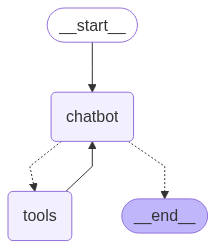

In [7]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！どういったことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことはありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "お住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n## 鯉｜もっとも手軽で簡単な大物\n\n難易度：★☆☆｜平均70cm、1m超えれば超絶レア  \n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！\n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n釣り好き！まっちゃん\n\n### 1mを超えるコイは超絶レアですよ！\n\n身近な川魚のコイといえども最大サイズは1ｍを優に超え、コイを専門に狙う釣り人にとってメーター超えの巨鯉は一生に1匹でも良いから釣ってみたい憧れのサイズです。\n\nメーターオーバーのコイは幻級の魚ですが、90cm前後までのコイは都市型河川でもよく見かけますので、パンコイゲームを楽しみに行かれる際は、メジャーも一緒に持って行ってみてはいかがでしょうか。\n\nダイワ \n\nフィッシングメジャーR 150cm\n\nこの商品を見る [...] 釣り方は練餌を使ったヘラブナ釣りを大がかりにしたような釣りになるため、ウキ釣りの経験がある方なら比較的簡単に感じるかもしれませんが、魚釣り初心者の方には少しハードルの上がる釣りと言えるでしょう。\n\n巨体に見合わない小さなアタリをヘラブナ用の棒ウキを使ってアワセていくのが醍醐味。掛かったらズシッっと1m級の魚の重みが竿にのしかかってきますよ！\n\n▼初心者でもトライできるブッコミ釣りスタイルで狙ったハクレン釣り\n\n関東の怪魚“ハクレン”を発泡スチロールで釣る！\n\n山根央之\n\n## ソウギョ｜全国各地で狙えるメーターオーバー\n\n難易度：★★☆｜平均1m\n\n日本各地の池や沼・川や水路には、水草の除草目的で放たれたソウギョという大型魚が棲んでいることがあります。\